In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [2]:
data = pd.read_csv('spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [3]:
data.shape

(5171, 4)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [5]:
data['label'].value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

In [6]:
data['text'][0]

"Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nactivity you can obtain from gas control .\r\nthis change is needed asap for economics purposes ."

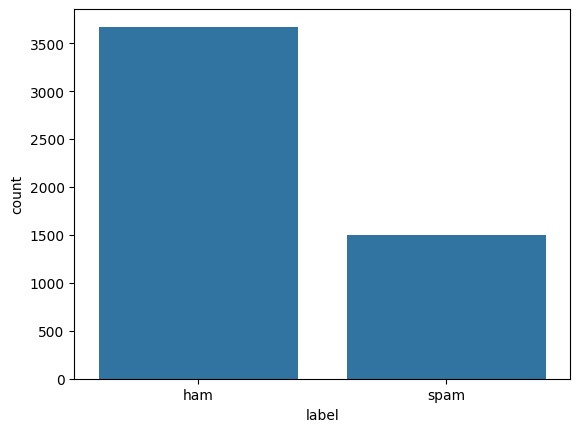

In [7]:
sns.countplot(x='label', data=data)
plt.show()

In [8]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

In [9]:
# Downsample Ham emails to match the number of Spam emails
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

In [10]:
# Combine balanced data
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

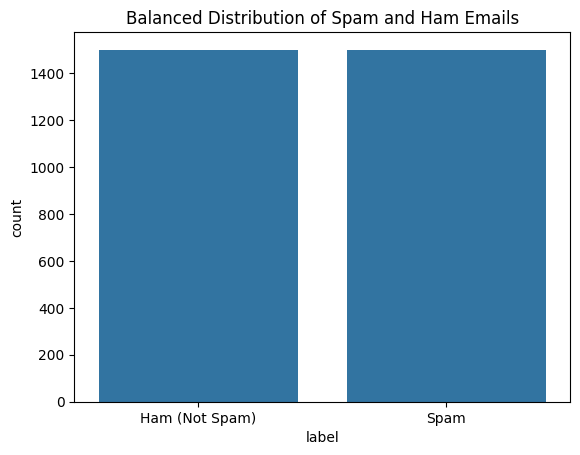

In [11]:
# Visualize the balanced dataset
sns.countplot(x='label', data=balanced_data)
plt.title("Balanced Distribution of Spam and Ham Emails")
plt.xticks(ticks=[0, 1], labels=['Ham (Not Spam)', 'Spam'])
plt.show()

In [12]:
balanced_data.shape

(2998, 4)

In [13]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0
2,2711,ham,": california energy crisis\r\ncalifornia  , s...",0
3,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [14]:
punctuations_list = string.punctuation
punctuations_list

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


In [16]:
len(stopwords.words('english'))

198

In [17]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data['text'][0]

'conoco big cowboy darren sure help know else ask april may gas pathed deal 133304 conoco gepl big cowboy point conoco saying buy gas accounted hpl big cowboy gas think paid 1 5 mil month gepl gas know added gepl meter deal april could bought gas someone else meter statements tejas say supply company megan'

In [18]:
import sys
print(sys.executable)

C:\Users\Hp\AppData\Local\Programs\Python\Python312\python.exe


In [19]:
!C:/Users\Hp\AppData\Local\Programs\Python\Python312\python -m pip install wordcloud


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: C:\Users\Hp\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [20]:
import wordcloud

In [21]:
from wordcloud import WordCloud

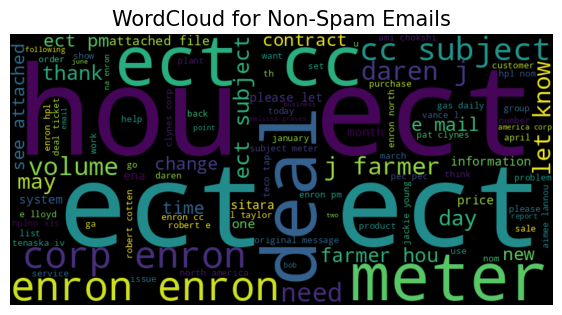

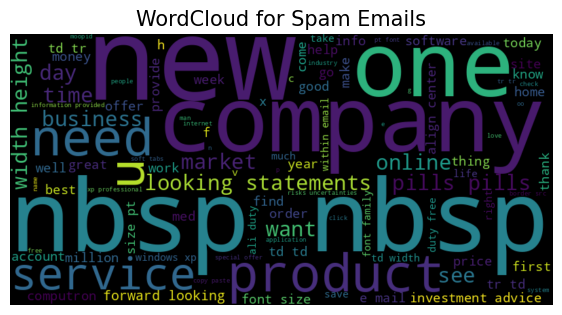

In [22]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')

In [23]:
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42)

In [24]:
tokenizer = Tokenizer()
tokenizer

In [25]:
tokenizer.fit_on_texts(train_X)

In [26]:
train_sequences = tokenizer.texts_to_sequences(train_X)
len(train_sequences)

2398

In [27]:
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100  # Maximum sequence length
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)

In [28]:
len(train_sequences)

2398

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit( train_sequences, train_Y, validation_data=(test_sequences, test_Y), epochs=20, batch_size=32, callbacks=[lr, es])

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5449 - loss: 0.6920 - val_accuracy: 0.5983 - val_loss: 0.6631 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8213 - loss: 0.4465 - val_accuracy: 0.9283 - val_loss: 0.2554 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9338 - loss: 0.2473 - val_accuracy: 0.9150 - val_loss: 0.2851 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9148 - loss: 0.2771 - val_accuracy: 0.9283 - val_loss: 0.2652 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9634 - loss: 0.1771 - val_accuracy: 0.9733 - val_loss: 0.1195 - learning_rate: 5.0000e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9807 - loss: 0.0989 - val_accuracy: 0.8450 - val_loss: 0.5317 - learning_rate: 5.0000e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9498 - loss: 0.1856 -

In [31]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9768 - loss: 0.1103
Test Loss : 0.1195119097828865
Test Accuracy : 0.9733333587646484


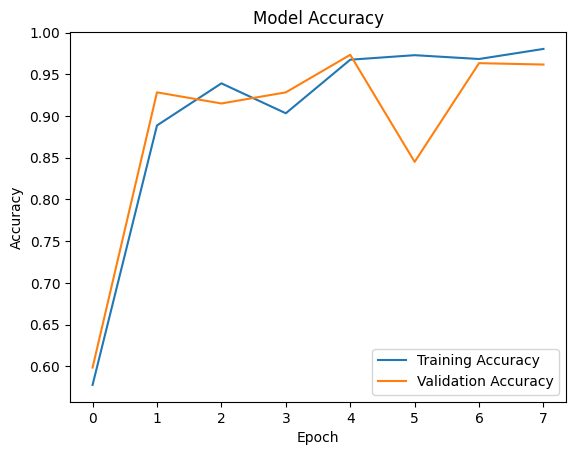

In [32]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()